# Incomplete Data 

Creating accurate predictions is one of the most valuable skills in the job market today. Statisticians, economists, and data scientists use data gathered from specific populations in order to predict the future. Through computational and statistical techniques, we can make _statistical inferences_ to draw conclusions from data that are often incomplete.

As far as estimations of parameters that already exist, having full population data would mean that our questions about that population are answered. But because the cost of gathering a full set of information typically outweigh the benefits of having perfectly accurate data, we are okay with use data samples to draw inferences about past data and predict future observations. 

## Are Mutual Funds better than Broad-market index funds? 

The term “index fund” refers to the investment approach of a fund. Specifically, it is a fund that that aims to match the performance of a particular market index, such as the S&P 500 or Russell 2,000. The index fund simply tries to match the market. This differs from a more actively managed fund, in which investments are picked by a fund manager in an attempt to beat the market. The age old question is: are the fees payed to an actively-managed mutual fund worth it? 

We could simply compare the mean return from a given date range for a mutual fund and compare it to the S&P500s mean return from the same time interval, and see which is higher. But the fact that mutual funds have a limited number of time intervals which we can sample means we cannnot rule out the possibility that higher or lower returns from the fund were a result of random variation, and not an indicator of the true quality of the fund. Returns to investment in the S&P500 is a quality proxy for returns in equity markets. Although returns to the S&P 500 experience stochasticity, on average the average rate of return from a mutual fund data should beat S&P returns on average if active investment is actually improving the rate of return. So, we need to analyze the two funds using statistical techniques which account for random variation that is possible from incomplete data. 

We would like to ananlyze which(if any) mutual funds have out-performed the market, fees included. To start, we read the CSV downloaded from [Stock Market MBA](https://stockmarketmba.com/listoftop100activelymanagedusstockmutualfunds.php), which shows the 100 largest actively-managed mutual funds in the US. 

In [1]:
import numpy as np
import pandas as pd

mutual_fund_data = pd.read_csv("Top100MutualFunds.csv")
mutual_fund_data

,Symbol,Name,Category1,Category2,Category3,Morningstar Category,Morningstar Rating,Market cap,Current yield,Fees,Action
0,AGTHX,American Funds The Growth Fund of America Class A,US Equity,Broad market,Large cap,Large Growth,3.0,"$138,592,080,000",0.22%,0.62%,Analyze
1,FCNTX,Fidelity Contrafund Fund,US Equity,Broad market,Large cap,Large Growth,3.0,"$121,762,870,000",0.00%,0.74%,Analyze
2,CWMAX,American Funds Washington Mutual Investors Fun...,US Equity,Broad market,Large cap,Large Blend,3.0,"$113,300,000,000",1.46%,0.63%,Analyze
3,CWMCX,American Funds Washington Mutual Investors Fun...,US Equity,Broad market,Large cap,Large Blend,3.0,"$113,300,000,000",0.79%,1.40%,Analyze
4,CWMEX,American Funds Washington Mutual Investors Fun...,US Equity,Broad market,Large cap,Large Blend,3.0,"$113,300,000,000",1.28%,0.87%,Analyze
...,...,...,...,...,...,...,...,...,...,...,...
95,FDTRX,Franklin DynaTech Fund Class R6,US Equity,Broad market,Large cap,Large Growth,5.0,"$9,600,000,000",0.00%,0.51%,Analyze
96,FDYZX,Franklin DynaTech Fund Advisor Class,US Equity,Broad market,Large cap,Large Growth,5.0,"$9,600,000,000",0.00%,0.62%,Analyze
97,BBVLX,Bridge Builder Large Cap Value Fund,US Equity,Broad market,Large cap,Large Value,4.0,"$9,500,000,000",1.55%,0.25%,Analyze
98,PEYAX,Putnam Large Cap Value Fund Class A,US Equity,Broad market,Large cap,Large Value,4.0,"$9,393,340,000",1.23%,0.91%,Analyze


We don't need to include every category for each fund. Let's drop all categories except for the Morningstar Category. We'll also drop the Morningstar Rating and Action columns.

In [2]:
to_drop = [
    "Category2", "Category1", "Category3", "Morningstar Rating",
    "Current yield", "Action"
]
mutual_fund_data = mutual_fund_data.drop(columns=to_drop)
mutual_fund_data.head()

,Symbol,Name,Morningstar Category,Market cap,Fees
0,AGTHX,American Funds The Growth Fund of America Class A,Large Growth,"$138,592,080,000",0.62%
1,FCNTX,Fidelity Contrafund Fund,Large Growth,"$121,762,870,000",0.74%
2,CWMAX,American Funds Washington Mutual Investors Fun...,Large Blend,"$113,300,000,000",0.63%
3,CWMCX,American Funds Washington Mutual Investors Fun...,Large Blend,"$113,300,000,000",1.40%
4,CWMEX,American Funds Washington Mutual Investors Fun...,Large Blend,"$113,300,000,000",0.87%


The symbols column from *mutual_fund_data* contains the ticker symbol that we can use to download data from each fund.  If you have not yet done so, install the module using:

In [3]:
#!pip install pandas-datareader

Next we need to prepare to download the data. We can save the list of symbols and pass each symbol to pandas_datareader. We also need to choose the range of dates to include. Finally, we will save each fund in a dictionary using the ticker sympol as the key for data for that symbol.

In [4]:
import pandas_datareader as web
import datetime as dt

mutual_fund_dict = {}
symbols = mutual_fund_data["Symbol"]

start = dt.datetime(1980, 1, 1)
end = dt.datetime(2020, 1, 1)
(start, end, symbols)

(datetime.datetime(1980, 1, 1, 0, 0),
 datetime.datetime(2020, 1, 1, 0, 0),
 0     AGTHX
 1     FCNTX
 2     CWMAX
 3     CWMCX
 4     CWMEX
       ...  
 95    FDTRX
 96    FDYZX
 97    BBVLX
 98    PEYAX
 99    TWCGX
 Name: Symbol, Length: 100, dtype: object)

Now we are ready to download the data. 

In [5]:
#pull mutual fund data for our chosen timeframe
fund_data = web.DataReader(
    symbols, 
    'yahoo', 
    start=start,
    end=end) 

Display the DataFrame we just made: 

In [6]:
fund_data

Attributes  Adj Close                                                         \
Symbols         AGTHX      FCNTX      CWMAX      CWMCX      CWMEX      CWMFX   
Date                                                                           
1980-01-02   0.669569   0.134105        NaN        NaN        NaN        NaN   
1980-01-03   0.681248   0.132336        NaN        NaN        NaN        NaN   
1980-01-04   0.681248   0.134341        NaN        NaN        NaN        NaN   
1980-01-07   0.698766   0.133869        NaN        NaN        NaN        NaN   
1980-01-08   0.706552   0.137643        NaN        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
2019-12-24  45.222630  11.200621  42.041508  42.582386  41.984276  41.686699   
2019-12-26  45.452366  11.290684  42.164051  42.707283  42.116238  41.808556   
2019-12-27  45.443531  11.290684  42.181561  42.725124  42.133835  41.825970   
2019-12-30  45.045910  11.200621  41.962723  42.493168  41.905087  41.599655   
2019-12-31  45.178455  11.225183  42.041508  42.573467  41.984276  41.686699   

Attributes                                              ... Volume        \
Symbols         AIVSX      AWSHX      ANCFX      AMCFX  ...  CMGIX SBLYX   
Date                                                    ...                
1980-01-02        NaN   0.689292   0.742943        NaN  ...    NaN   NaN   
1980-01-03        NaN   0.685189   0.738798        NaN  ...    NaN   NaN   
1980-01-04        NaN   0.695446   0.750196        NaN  ...    NaN   NaN   
1980-01-07        NaN   0.700575   0.753305        NaN  ...    NaN   NaN   
1980-01-08        NaN   0.713910   0.771957        NaN  ...    NaN   NaN   
...               ...        ...        ...        ...  ...    ...   ...   
2019-12-24  35.401695  42.123878  52.561497  28.316502  ...    0.0   0.0   
2019-12-26  35.553867  42.255104  52.799057  28.408522  ...    0.0   0.0   
2019-12-27  35.553867  42.272598  52.849964  28.400156  ...    0.0   0.0   
2019-12-30  35.312187  42.045139  52.485130  28.216120  ...    0.0   0.0   
2019-12-31  35.419609  42.123878  52.620880  28.283043  ...    0.0   0.0   

Attributes                                                  
Symbols    AKRIX MFEGX FDNRX FDTRX FDYZX BBVLX PEYAX TWCGX  
Date                                                        
1980-01-02   NaN   NaN   NaN   NaN   NaN   NaN   0.0   0.0  
1980-01-03   NaN   NaN   NaN   NaN   NaN   NaN   0.0   0.0  
1980-01-04   NaN   NaN   NaN   NaN   NaN   NaN   0.0   0.0  
1980-01-07   NaN   NaN   NaN   NaN   NaN   NaN   0.0   0.0  
1980-01-08   NaN   NaN   NaN   NaN   NaN   NaN   0.0   0.0  
...          ...   ...   ...   ...   ...   ...   ...   ...  
2019-12-24   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2019-12-26   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2019-12-27   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2019-12-30   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2019-12-31   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[10087 rows x 600 columns]

As we can see, there are many null values for the earlier dates of the DataFrame because many of the funds did not exist in 1980. For aesthetic purposes, we can use the df.tail() method to only show the last 5 rows from now on. 

In [7]:
# there will be many null values at the head of the df so use the .tail() method for the last 5 rows 
fund_data.tail()

Attributes  Adj Close                                                         \
Symbols         AGTHX      FCNTX      CWMAX      CWMCX      CWMEX      CWMFX   
Date                                                                           
2019-12-24  45.222630  11.200621  42.041508  42.582386  41.984276  41.686699   
2019-12-26  45.452366  11.290684  42.164051  42.707283  42.116238  41.808556   
2019-12-27  45.443531  11.290684  42.181561  42.725124  42.133835  41.825970   
2019-12-30  45.045910  11.200621  41.962723  42.493168  41.905087  41.599655   
2019-12-31  45.178455  11.225183  42.041508  42.573467  41.984276  41.686699   

Attributes                                              ... Volume        \
Symbols         AIVSX      AWSHX      ANCFX      AMCFX  ...  CMGIX SBLYX   
Date                                                    ...                
2019-12-24  35.401695  42.123878  52.561497  28.316502  ...    0.0   0.0   
2019-12-26  35.553867  42.255104  52.799057  28.408522  ...    0.0   0.0   
2019-12-27  35.553867  42.272598  52.849964  28.400156  ...    0.0   0.0   
2019-12-30  35.312187  42.045139  52.485130  28.216120  ...    0.0   0.0   
2019-12-31  35.419609  42.123878  52.620880  28.283043  ...    0.0   0.0   

Attributes                                                  
Symbols    AKRIX MFEGX FDNRX FDTRX FDYZX BBVLX PEYAX TWCGX  
Date                                                        
2019-12-24   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2019-12-26   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2019-12-27   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2019-12-30   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2019-12-31   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 600 columns]

The column names have two layers. We are interested in the adjusted close data. Save this data as a unique dataframe, *close_data*, by selecting the key "Adj Close" from *fund_data*.

In [8]:
close_data = fund_data["Adj Close"]
close_data.tail()

Symbols,AGTHX,FCNTX,CWMAX,CWMCX,CWMEX,CWMFX,AIVSX,AWSHX,ANCFX,AMCFX,...,CMGIX,SBLYX,AKRIX,MFEGX,FDNRX,FDTRX,FDYZX,BBVLX,PEYAX,TWCGX
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-24,45.222630,11.200621,42.041508,42.582386,41.984276,41.686699,35.401695,42.123878,52.561497,28.316502,...,28.723635,46.490227,43.900551,111.045128,84.588425,91.422066,90.450050,12.381691,23.032425,30.484949
2019-12-26,45.452366,11.290684,42.164051,42.707283,42.116238,41.808556,35.553867,42.255104,52.799057,28.408522,...,28.780684,46.865356,44.026039,111.763832,85.140511,92.024178,91.042191,12.426750,23.116102,30.753319
2019-12-27,45.443531,11.290684,42.181561,42.725124,42.133835,41.825970,35.553867,42.272598,52.849964,28.400156,...,28.790192,46.839779,44.083950,111.866501,85.239098,92.122879,91.140884,12.426750,23.107386,30.736549
2019-12-30,45.045910,11.200621,41.962723,42.493168,41.905087,41.599655,35.312187,42.045139,52.485130,28.216120,...,28.571507,46.447598,43.929508,111.026443,84.420815,91.244392,90.272408,12.363669,23.020220,30.493340
2019-12-31,45.178455,11.225183,42.041508,42.573467,41.984276,41.686699,35.419609,42.123878,52.620880,28.283043,...,28.647572,46.558434,44.026039,111.269135,84.578560,91.412193,90.430305,12.398057,23.063801,30.552042


We will want to compare the returns earned by each fund to the returns earned by investment in the S&P 500 index. We will save the S&P 500 data as a new column in the same data frame, *close_data*.

In [9]:
close_data["S&P 500"] = web.DataReader(
    '^GSPC', 
    'yahoo', 
    start=start,
    end=end)['Adj Close']

<ipython-input-9-96a3e63cb6d0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_data["S&P 500"] = web.DataReader(


In [10]:
close_data["S&P 500"].tail()

Date
2019-12-24    3223.379883
2019-12-26    3239.909912
2019-12-27    3240.020020
2019-12-30    3221.290039
2019-12-31    3230.780029
Name: S&P 500, dtype: float64

Since data for many of the funds considered do not span many years, we will compare monthly returns for each fund to monthly returns to the S&P 500.

To do this, we use the Pandas _.resample("M")_ method, with the "M" specifying that we would like a monthly frequency. Then, we take the _.pct_change()_ on our monthly data.  

In [11]:
monthly_close_data = close_data.resample("M").first()
monthly_close_data.tail()

Symbols,AGTHX,FCNTX,CWMAX,CWMCX,CWMEX,CWMFX,AIVSX,AWSHX,ANCFX,AMCFX,...,SBLYX,AKRIX,MFEGX,FDNRX,FDTRX,FDYZX,BBVLX,PEYAX,TWCGX,S&P 500
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-31,41.335762,10.460318,38.487007,39.087692,38.474609,38.125050,32.312153,38.554379,47.407993,25.792034,...,43.339317,42.063946,103.062218,82.111740,88.519318,87.616592,11.407798,20.678925,27.987558,2953.560059
2019-09-30,40.321743,10.230855,38.133842,38.700684,38.110836,37.782639,31.743792,38.201435,46.335098,25.256033,...,42.144035,42.963913,103.053009,80.663971,87.010185,86.107826,11.291302,20.374943,27.455748,2906.270020
2019-10-31,40.165104,10.096343,38.581974,39.137318,38.555397,38.233120,31.931023,38.654240,46.908035,25.128031,...,42.298523,42.307690,101.679955,77.836914,84.001724,83.129463,11.449296,20.879229,27.423996,2940.250000
2019-11-30,42.275589,10.547355,39.966839,40.516609,39.930859,39.609375,33.191574,40.038372,49.365051,26.328033,...,43.973553,43.235771,104.886826,80.028130,86.412415,85.500389,11.890692,21.921915,28.630495,3066.909912
2019-12-31,43.372051,10.800555,40.600163,41.137280,40.559158,40.255543,33.932568,40.679798,50.489178,27.064039,...,44.892380,43.142025,107.255112,81.788521,88.362152,87.420242,11.989780,22.210138,29.448057,3113.870117


In [12]:
#calculate percent change from previous month
monthly_returns = monthly_close_data.pct_change()
monthly_returns.tail()

Symbols,AGTHX,FCNTX,CWMAX,CWMCX,CWMEX,CWMFX,AIVSX,AWSHX,ANCFX,AMCFX,...,SBLYX,AKRIX,MFEGX,FDNRX,FDTRX,FDYZX,BBVLX,PEYAX,TWCGX,S&P 500
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-31,-0.012409,-0.005267,-0.005216,-0.005906,-0.005467,-0.005013,-0.008589,-0.005204,-0.009369,-0.015572,...,0.003011,0.016308,0.005213,0.007441,0.007810,0.007776,-0.004691,-0.006491,0.006278,-0.003633
2019-09-30,-0.024531,-0.021936,-0.009176,-0.009901,-0.009455,-0.008981,-0.017590,-0.009154,-0.022631,-0.020782,...,-0.027580,0.021395,-0.000089,-0.017632,-0.017049,-0.017220,-0.010212,-0.014700,-0.019002,-0.016011
2019-10-31,-0.003885,-0.013148,0.011752,0.011282,0.011665,0.011923,0.005898,0.011853,0.012365,-0.005068,...,0.003666,-0.015274,-0.013324,-0.035047,-0.034576,-0.034589,0.013993,0.024750,-0.001156,0.011692
2019-11-30,0.052545,0.044671,0.035894,0.035242,0.035675,0.035996,0.039477,0.035808,0.052379,0.047756,...,0.039600,0.021936,0.031539,0.028151,0.028698,0.028521,0.038552,0.049939,0.043994,0.043078
2019-12-31,0.025936,0.024006,0.015846,0.015319,0.015735,0.016314,0.022325,0.016020,0.022772,0.027955,...,0.020895,-0.002168,0.022579,0.021997,0.022563,0.022454,0.008333,0.013148,0.028556,0.015312


In [13]:
avg_monthly_return = monthly_close_data.loc["2015":].dropna(axis = 1)
num_months = avg_monthly_return.shape[0]
avg_monthly_return = avg_monthly_return.iloc[-1].div(avg_monthly_return.iloc[0])
avg_monthly_return = avg_monthly_return.pow(1 / num_months).sub(1)

Now that we have out data wrangled and prepped, we can compute some basic statistics to understand the distribution of our dataset. The easiest method to start with is using the Pandas _df.describe()_ method, which gives us basic descriptive statistics for each series in our dataframe. 

In [14]:
avg_monthly_return.describe()

count    91.000000
mean      0.008867
std       0.002076
min       0.003378
25%       0.007389
50%       0.008292
75%       0.010792
max       0.012552
dtype: float64

We can also display a visual of our distributions by using a histogram. Usually, rates of change like we are dealing with in stock prices will display a normal-looking distribution. We can take the mean change of the entire dataset and the mean standard deviation of the entire dataset to be entered into a normal distribution function that we can overlay over our data's histogram to visually check for normality. 

<AxesSubplot:xlabel='Date'>

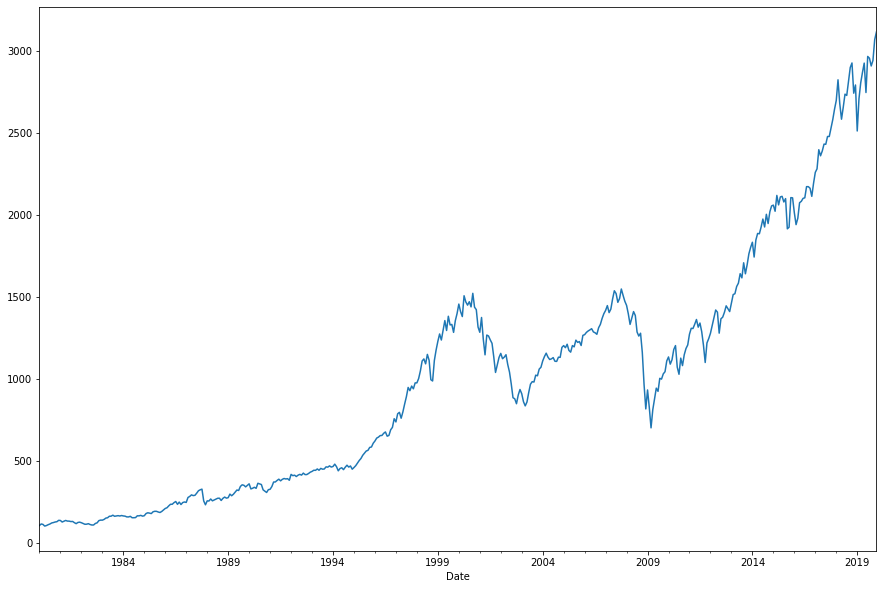

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (15,10))
monthly_close_data["S&P 500"].plot.line(ax = ax)

In [16]:
# find the mean of the mean monthly changes and the mean standard deviation of changes
mu = monthly_returns.mean().mean()
sigma = monthly_returns.var().mean()** .5
print(mu, sigma)

0.009543018435470988 0.04655114491671479


In [17]:
n = monthly_returns.notna().sum().sum()
np.sqrt(n)

158.905632373431

Text(0.5, 1.0, 'Distributions of Various Index Fund Returns')

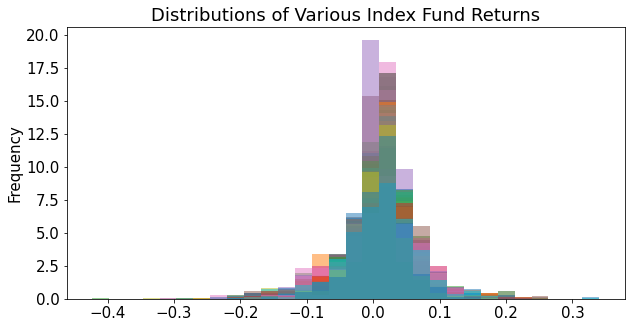

In [91]:
import matplotlib.pyplot as plt
import scipy.stats as stats

fig, ax = plt.subplots(figsize=(10, 5))

#plot the funds distributions
monthly_returns.plot.hist(bins=30, ax=ax, density=True, alpha=.5, legend=False)

ax.set_title(
    "Distributions of Various Index Fund Returns"
)

In [19]:
diff_from_sp500 = []
for symbol in symbols:
    diff_from_sp500.extend(monthly_returns[symbol].dropna() - monthly_returns["S&P 500"].dropna())

In [20]:
diff_from_sp500 = pd.Series(diff_from_sp500)

In [21]:
diff_from_sp500.mean()

0.001999485239940292

In [22]:
avg_monthly_return.mean()

0.008867352506105356

<AxesSubplot:ylabel='Frequency'>

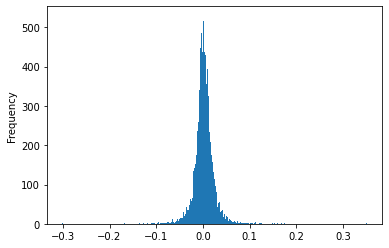

In [23]:
diff_from_sp500.plot.hist(bins=1000)

We have successfully wrangled and prepped our data and can now begin statistical analysis on it. 

# Hypothesis Testing and Confidence Intervals

Statistical inference may be divided into two major areas: tests of hypothesis and estimation. __Hypothesis tests__ make inference about whether a sample parameter relates to a singular value in a chosen way, i.e., the same as that value.  __Estimations__ give a range of values that a sample parameter could take, with a chosen level of probability, called a confidence interval. 

These topics are sometimes taught seperately, this section will attempt to teach them together as they are directly related.
The need for both methods can be demonstrated using our mutual fund and S&P 500 data. Imagine we wanted to see if a given mutual fund outperformed the S&P 500 during the great recession(December 2007 to June 2009), and if it did, was the difference more likely due to randomness or because the fund was actually more resilient? These answers wil come from performing a hypothesis test. On the other hand, if we wanted a range of returns we could be 95% certain would contain the mean return of the S&P 500 if a recession similar to the great recession were to happen again, we would want a confidence interval.

This idea of finding a range of possibilities for events that have already happened is not intuitive. What does it mean to create a confidence interval for past S&P500 returns? Haven't these returns already happened?

Although the returns have been observed, we assume that _randomness_ had a large influence on these returns. Theoretically, if we were to re-run the same time period of S&P500 returns, we would expect them to be different, ceteris paribus, _within a confidence interval_. This is definitionally randomness. There is no causal effect. The range of expected randomness for a relatively complete dataset like previous S&P500 returns is the standard error of the mean for that dataset, which will be smaller as the sample size increases. Randomness has less effect on larger datasets. 

## Hypothesis tests
As the name suggests, hypothesis tests use __hypotheses__. These are mutually exclusive, falsifiable statements. Only one can be true, and one of them will be true. Generally, these are the hypothses we begin with: 

- The _null_ hypothesis $H_o$: The true means of the the sample populations do not differ.
- The _alternate_ hypothesis $H_a$: The true means of the sample populations do differ.

### Types of Error
when making an inference about the value of the parameter, there are two types of error we can make: 

- Type 1 Error: This is the incorrect denial of a true null hypothesis - a "false positive"
- Type 2 Error: This is the incorrect acceptance of a false null hypothesis - a "false negative" 

In statistics, type 1 error is denoted by the Greek letter $\alpha$ and is called the significance level. Usually, the significance level is set to 0.05 (5%), implying that it is acceptable to have a 5% probability of incorrectly rejecting the true null hypothesis. Hence, most hypothesis tests are 95% confident in their inferences about a parameter and most confidence intervals give a range of values that the tester is 95% confident contains the true parameter. 

The probability of a type 2 error is denoted $\beta$ and $1-\beta$ is known as the power of the test. 

These two types of error are heavily related, and the tester faces a tradeoff - generally, when the probability of one type of error is minimized, the other increases. However the probability of committing both types of error decreases as the sample size increases. 

### Hypothesis Testing with Mutual Funds 
In the case of us determining the efficacy of an investment strategy, we must compare the return on strategy to the average return approximated by returns on investment in the S&P 500. These are our hypotheses: 

- $H_o$: There is no difference between the mutual fund's and S&P500's average monthly return. 
- $H_a$: The mutual funds have a higher mean gain than the S&P500. 

In particular, we would like to know if the mean returns for any and each index funds are different from and higher than returns earned by the S&P 500.

### T-values

The t-value, returned from the __T-test__ is used when we are dealing with a population of unknown, but normal, distribution. We have to check this assumption of normality prior to any t-test. Once we have done that, we can compare a given sample mean to one of three options: 

- **One Sample T-test:** The one sample t test compares the mean of your sample data to a known value. For example, we can compare a given funds average monthly return to some arbitrary value, like 7% or 10%. 
<h3 align="center">
    <font size="6">
        $t = \frac{\bar{X} - \mu}{\frac{s}{\sqrt{n}}}$
    </font>
    </h3> 
    
    
   - Null Hypothesis: sample mean is the same as hypothesized or theoretical mean
   - Alternative Hypothesis: sample mean is different from the hypothesized or theoretical mean
   - $\bar{X}$ is the sample mean 
   - $ \mu$ is the hypothesized value
   - $ \frac{s}{\sqrt{n}}$ is the standard error of the mean. The standard error of the mean is the standard deviation of the t-distribution with a given degrees of freedom. 

In [24]:
def t_value_1samp(data, mu):
    x_bar = np.mean(data)
    s = np.std(data)
    n = len(data)
    df = n - 1
    t = (x_bar - mu) / (s / np.sqrt(n))
    
    #return both t and df to be used later in p-value calculations
    return t, df

We can find the t-value for comparing the mean S&P500 monthly return to any rate we would like, in this example we choose the monthly rate that corresponds to a 7% yearly return: 

In [25]:
sp500 = monthly_returns["S&P 500"].dropna()

In [26]:
sp500.mean()

0.008060322272859285

We can use the future value equation to calculate the monthly rate needed to obtain a yearly rate of $R$, given by this equation: 

>$ r = (R)^{\frac{1}{t}} - 1$
>
>$t$ is the time period of measurement 

A 7% annnualized rate is a monthly rate of the 12 root of 1.07: $1.07^\frac{1}{12} - 1$
Discount the overall rate of return to find the average rate of return. We will use this to define the mean of the standard normal distribution:

In [27]:
hypothesized_rate = 1.07 **(1/12) - 1
hypothesized_rate

0.005654145387405274

In [28]:
t_value_1samp(data=sp500, mu=hypothesized_rate)

(1.2026921542289366, 478)

In [29]:
stats.ttest_1samp(sp500, hypothesized_rate).statistic

1.2014360785293432

This result suggests the S&P500s monthly return was only 0.205 of the S&P500's standard errors ($\frac{s}{\sqrt(n)}$) lower the hypothesized rate of a 7% yearly return. Further analysis of the probability of this result is discussed later in this chapter. 

- **Independent Samples T-test:** The The independent samples t test (also called the unpaired samples t test) helps you to compare the means of two sets of data that came from different sources. Normally, we are checking to see if the means of the data are significantly different from a differnece of zero. But , we can also check if they are significantly different from a hypothesized or theoretical value. For instance, say we had two groups of males and one group of females and we wanted to compare average heights between the groups. For the males, we would check to see if they differed significantly from an average height difference of zero, whereas when comparing the males to the females we may want to see if they were significantly different from an average difference of 2 inches. **This hypothesized difference, $(\mu_1 - \mu_2)$, will usually be zero, but not always.**

<h3 align="center">
    <font size="6">
        $ t = \frac{(\bar{x_1}-\bar{x_2})-(\mu_1 - \mu_2)}{\sqrt{\frac{s^2_1}{n_1}+\frac{s^2_2}{n_2}}}$
    </font>
    </h3> 
    
   
   - Note that this t-test is one variation of the independent samples t-test that _does not_ assume equal variance between the samples
   
    - Null Hypothesis: sample mean is the same as hypothesized or theoretical mean
    - Alternative Hypothesis: sample mean is different from the hypothesized or theoretical mean
    

In [105]:
# independent samples t-test, setting equal_var=True will turn this test into a paired samples t-test where equal variance
# is assumed
def t_value_ind_samp(a, b, hypothesized_difference=0, equal_var=False):
    
    a = np.array(a)
    b = np.array(b)
    
    s1, n1 = np.var(a) , len(a)
    s2, n2 = np.var(b),  len(b)
    
    # if paired samples, df calculation is different
    if (equal_var):
        df = n1 + n2 - 2
        svar = ((n1 - 1) * s1 + (n2 - 1) * s2) / float(df)
        denom = np.sqrt(svar * (1.0 / n1 + 1.0 / n2))
    else:
        vn1 = s1 / n1
        vn2 = s2 / n2
        df = (vn1 + vn2)**2 / (vn1**2 / (n1 - 1) + vn2**2 / (n2 - 1))
        denom = np.sqrt(vn1 + vn2)

    d = np.mean(a) - np.mean(b) - hypothesized_difference
    t = d / denom
    return t, df

A good example of the independent samples t-test is comparing the S&P500 to a mutual fund from our data, rather than to a hypothesized value as we did with the single-sample t-test. We use data to one of the older funds, T. Rowe Price Growth Stock Fund (PRGFX).

In [97]:
prgfx = monthly_returns["PRGFX"].dropna()
sp500.mean(), prgfx.mean()

(0.008060322272859285, 0.008289481419430996)

In [107]:
t_value_ind_samp(sp500, prgfx)

(-0.07779120600156811, 950.2911817451942)

In [108]:
stats.ttest_ind(sp500, prgfx).statistic

-0.07770996190002742

This result tells us that PRGFX's mean is 0.589 standard errors higher than the S&P500's. 

- **Paired Samples T-test:** A paired t test (also called a correlated pairs t-test, a paired samples t test or dependent samples t test) is where you run a t test on dependent samples. Dependent samples are essentially connected — they are tests on the same person or thing. This would be useful for us if we were doing some sort of scientific treatment to the same population - not something that is done to mutual funds. For our function, we can simply add an optional argument "equal_var" to our independent t-test funtion which will cause it to act like a paired samples t-test. 

### The T Probability Distribution
When comparing two samples drawn from a population with unknown parameters, we return a t-value(defined below) similar to the z-value, and a corresponding degrees of freedom, indicating the size of our samples. If the size of our samples is high, we can have more confidence in our result. The t-distribution is defined as: 

<h3 align="center">
    <font size="6">
        $ f(T) = \frac{(1 + \frac{T^2}{\nu})^{\frac{-(\nu+1)}{2}}}{B(0.5,0.5\nu)\sqrt(\nu)}$
    </font>
    </h3> 

    
- Where $\nu$ is the degrees of freedom of the distribution and B is the beta function, which is beyond the scope of this book and can be pulled from the scipy.stats library. 
- This is the same distribution shown in the previous chapter; the Cauchy has one degree of freedom and the Standard normal is the form of the t-distribution with more than 30 degrees of freedom

We can implement this distribution in code: 

In [34]:
import scipy.special as sc

# define a function to create the actual distribution from which we can analyze our t value from the t test
def t_distribution(df, t): 
    t_dist_val = ((1 + t**2 / df)
                      **(-(df + 1) / 2)) / (sc.beta(.5, .5 * df) * np.sqrt(df))
    return t_dist_val

And then plot it: 

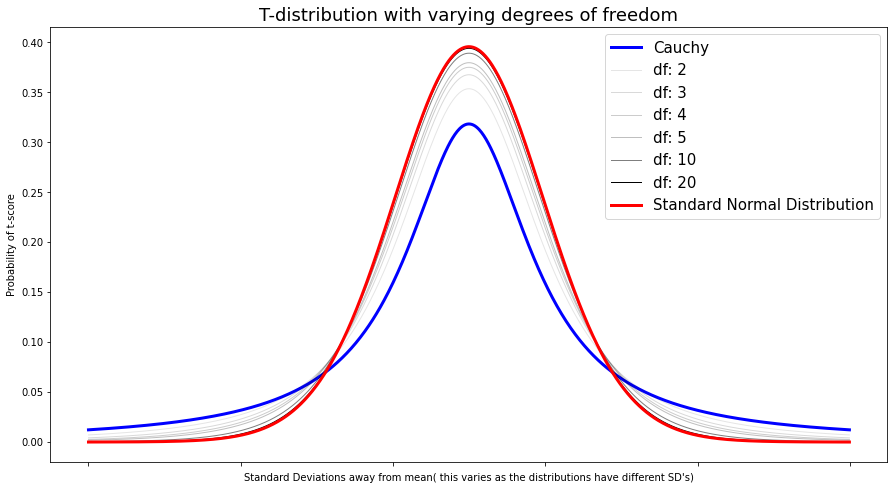

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))

x = np.linspace(-5, 5, 1000)
cauchy = t_distribution(1, x)
ax.plot(cauchy, '-', lw=3, alpha=1, label="Cauchy", color='b')
t_df = [2, 3, 4, 5, 10, 20]
for df in t_df:
    dist = t_distribution(df, x)
    ax.plot(dist, '-', lw=1, alpha=df / 20, label="df: " + str(df), color='k')
gaussian = t_distribution(30, x)
ax.plot(gaussian,
        lw=3,
        alpha=1,
        color='r',
        label='Standard Normal Distribution')
plt.rcParams.update({"font.size": 15})
ax.set_ylabel("Probability of t-score")
ax.set_xlabel(
    "Standard Deviations away from mean( this varies as the distributions have different SD's)"
)
plt.title("T-distribution with varying degrees of freedom")
ax.set_xticklabels(labels="")
plt.legend()

### T-distribution p-value

As we can see, a lower sample size, and hence a lower degrees of freedom, leads to a lower probaility that our t-score is near 0 when our population means are the same, because more random variation is likely when the sample size is so low. The point of a t-score is to determine if the difference in the two means of the samples is too drastic for the true population means to be the same. As we approach 30 with our degrees of freedom, the graph doesnt change much, and this is a standard normal distribution, which the z-score uses. Some textbooks say you can use z-score for large sample sizes; it will give nearly the same answer. 

Once we get our t-score, we plug it into the equation shown below to get it's p-value. The equation uses the t-distributions's __Cumulative Density Function__. This distribution models the probability that the random variable $T$ takes at most the value $t$. We get a corresponding __p-value__, shown on the y-axis. This value is the probability of our gotten t-value if the true means were the same. 

<h3 align="center">
    $ p =  2 \cdot (1-CDF_{t_{n-1}}(|t|)) $
<h3> 

This CDF, and all CDF's, can easily be modeled by, for each value t in our t-distribution, plotting t added to all previous t-values, since we used _np.linspace_ to discretely model this continuous distribution:

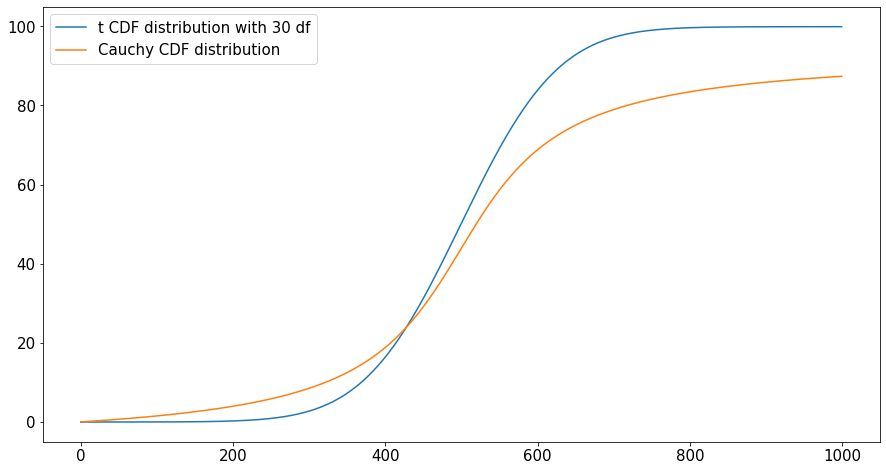

In [36]:
fig, ax = plt.subplots(figsize = (15,8))

#create t-dist with 30 df and with 1 df
x = np.linspace(-5, 5, 1000)
t_dist = t_distribution(30, x)
cauchy = t_distribution(1, x)

#go along the linspace that was created and add current value to all previous values
f_dist = t_dist.copy()
cauchy_f_dist = cauchy.copy()

for i in range(len(t_dist)): 
    f_dist[i] += f_dist[i-1]
    cauchy_f_dist[i] += cauchy_f_dist[i-1]

plt.plot(f_dist, label = 't CDF distribution with 30 df')
plt.plot(cauchy_f_dist, label = 'Cauchy CDF distribution')

plt.legend()

- If the corresponding p-value from our t-value is too low, we choose to __reject the null hypothesis $H_o$__, and say that our samples come from different populations who's means are different. This is a "statistically significant" result. 


- If the p-value is sufficiently high, we __fail to reject the null hypothesis $H_o$__, and say that there is a high enough chance that the samples came from populations with the same means. This is a "statistically insignificant" result. 


- The value at which significance occurs, $\alpha$, and is most commonly 0.05.


Next, we can make a master function that uses all of the t-tests we just built:

In [37]:
import scipy.stats as stats

# function that allows us to evaluate the t distribution at a given t value and df
def t_test(a, b, kind):
    
    if kind == 'one_sample': 
            t_val, df = t_value_1samp(a, b)
            print (t_val, df)
    elif kind  == 'independent': 
            t_val, df = t_value_ind_samp(a, b)
    elif kind == 'paired': 
            t_val, df = t_value_ind_samp(a, b, equal_var=True)
            
    # cdf gives probability of a value at least as extreme as observed happening; for two-sided tests this is doubled
    p_value = (1-stats.t.cdf(np.abs(t_val), df-1))  *2
    
    if p_value > .05:
        return_string = "T-value: " + str(t_val) + ", P-value: " + str(
            p_value) + ", Fail to reject null hypothesis."
    else:
        return_string = "T-value: " + str(t_val) + ", P-value: " + str(
            round(p_value, 5)) + ", Reject null hypothesis."
        
    return return_string

The function accepts $t$ and $\nu$ and returns a probability of the t value occuring if there truly was no difference between the the two sample means, or the single sample mean and one hypothesized mean. If we are intereted in knowing the p that the result is only < or >, we take the p value as is. Otherwise, if we are looking for any difference, we multiply it by 2. If the probability returned is too low, then we can reasonably assume that this means that the two means _are not truly different_. This is the core concept of statistical significance. The probability at which a non-significant difference becomes a significant one is most commonly 0.05. This means that if there is a less than 5 percent probability that the observed difference in means could have happened by chance, we can reasonably assume that the result didn't happen by chance. 

We can now implement the same t-test we perfomed earlier with our hypothesized return of a 7% yearly rate and the S&P 500, returning a p-value along with our t-statistic, using the one-sample t-test: 

In [38]:
hypothesized_rate = 1.07 **(1/12) - 1
t_test(sp500, hypothesized_rate, 'one_sample')

1.2026921542289366 478


'T-value: 1.2026921542289366, P-value: 0.2296921134606542, Fail to reject null hypothesis.'

In [39]:
stats.ttest_1samp(sp500, hypothesized_rate)

Ttest_1sampResult(statistic=1.2014360785293432, pvalue=0.2301770245213624)

However, if we change the hypothesized monthly rate to be a yearly return of 15%, we get a p-value that implies the S&P 500 would not have had a high chance at an 8% yearly return with the expected amount of randomness.

In [40]:
hypothesized_rate = 1.15 **(1/12) - 1
t_test(sp500, hypothesized_rate, 'one_sample')

-1.8266954251775742 478


'T-value: -1.8266954251775742, P-value: 0.06837037165570203, Fail to reject null hypothesis.'

In [41]:
stats.ttest_1samp(sp500, hypothesized_rate)

Ttest_1sampResult(statistic=-1.8247876487561137, pvalue=0.06865708229141582)

As well as the independent-samples t-test comparing PRGFX to the S&P 500: 

In [42]:
t_test(sp500, prgfx, 'independent')

'T-value: -0.07779120600156574, P-value: 0.9380105348957097, Fail to reject null hypothesis.'

In [43]:
stats.ttest_ind(sp500, prgfx)

Ttest_indResult(statistic=-0.07770996190002742, pvalue=0.9380750305454255)

## Confidence Intervals

The confidence interval gives us the range of values that have a $1-\alpha$ probability of containing the population mean, based off of our sample mean. Confidence intervals, as hypothesis tests do, make use of the standard error of the mean of a sample. For a sample with mean $\bar{x}$, the confidence interval lower and upper bounds, respectively, are found by these formulas: 
<h3 align="center">
    <font size="4">
        $ CI = {\bar{x} - t_{\frac{\alpha}{2}}\frac{s}{\sqrt{n}}, \bar{x} + t_{\frac{\alpha}{2}}\frac{s}{\sqrt{n}}}$
    </font>
    </h3> 
- Where $t_{\frac{\alpha}{2}}$ is the $1-\frac{\alpha}{2}$ quantile of the $t_{n-1}$ distribution

This function can be easily built in code using the _percent point function_ in Scipy. This function gives the percentage of the t distribution behind a given point. This is also known as the quintile. We first make a function to return the quintile in a t distribution associated with a given df and alpha level, and then make a function to make confidence interval for passed data: 

In [44]:
def t_quintile(df, alpha):
    q = (1.0+alpha)/2
    a = stats.t.ppf(q, df)
    return a

We can see what this returns for a t-distribution with degrees of freedom in the S&P 500's data and an alpha value of 0.05: 

In [45]:
t_quintile(len(sp500), 0.05)

0.06273964329541434

Now we make a function that is passed an array of data and an alpha value and returns a confidence interval: 

In [46]:
def confidence_interval(data, alpha):
    n = len(data)
    df = n - 1
    x_bar = np.mean(data)
    SE = np.std(data) / np.sqrt(n)
    CI_quintile = t_quintile(df, alpha)
    CI = x_bar - CI_quintile * SE, x_bar + CI_quintile * SE
    return CI

In [47]:
sp500_CI = confidence_interval(sp500, 0.05)
sp500_CI

(0.00793480150310036, 0.008185843042618211)

This equates to a yearly return CI of: 

In [48]:
sp500_yearly_CI = (1 + sp500_CI[0]) ** 12, (1 + sp500_CI[1]) ** 12

In [49]:
sp500_yearly_CI

(1.099484944751164, 1.1027755720067467)

We can say with 95% confidence that the true s&P 500 monthly return, not due to randomness, was somewhere between these two values. 

### The Link Between Hypothesis Testing and Confidence Intervals

By now, it may seem obvious that these two concepts are heavily related. Both use the standard error of the sample mean as an expected error region to make inferences about a parameter, and are given an alpha level $\alpha$ that governs our confidence in the result. Hypothesis testing requires a second value, either a hypothesized value or another sample mean, to compare to. Confidence intervals require a single array of data for which error bars can be formed. The error bars from a confidence interval give a plausible range of values that our population parameter could take. 

The link between the two methods is that hypothesis testing also draws error bars for each of it's passed values, and if the error bar regions overlap, we fail to reject $H_o$ and if they do not overlap we fail to reject $H_o$. We are almost doing the same statistical test, just using it a little bit differently. 

For example, we can anlyze the error bars for the mean monthly return of the S&P 500 and PRGFX: 

In [50]:
prgfx_CI = confidence_interval(prgfx, 0.05)
sp500_CI = confidence_interval(sp500, 0.05)
print("SP500 CI: ", sp500_CI,"\nPRGFX CI",prgfx_CI)

SP500 CI:  (0.00793480150310036, 0.008185843042618211) 
PRGFX CI (0.00815382373394347, 0.008425139104918523)


In [51]:
len(sp500)

479

In [52]:
monthly_returns.mean().rank

<bound method NDFrame.rank of Symbols
AGTHX      0.009903
FCNTX      0.010282
CWMAX      0.007093
CWMCX      0.006451
CWMEX      0.006715
             ...   
FDYZX      0.010642
BBVLX      0.007565
PEYAX      0.006190
TWCGX      0.011017
S&P 500    0.008060
Length: 101, dtype: float64>

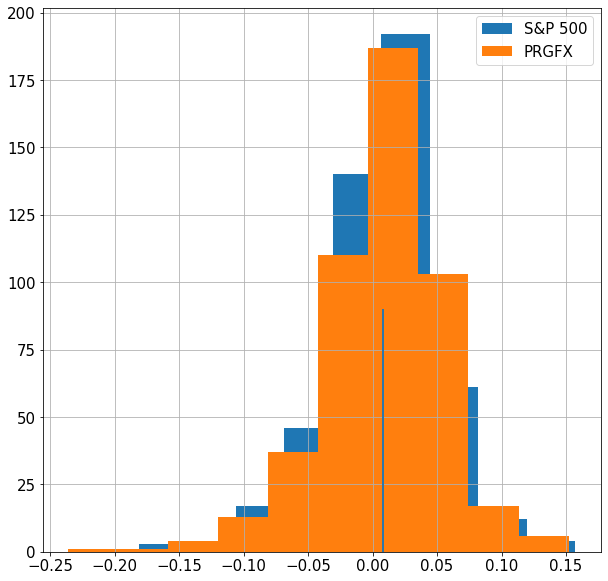

In [53]:
fig, ax = plt.subplots(figsize = (10, 10))
sp500.hist(ax=ax, label='S&P 500')
prgfx.hist(ax=ax, label='PRGFX')
ax.vlines(sp500.mean(), ymin = 0, ymax = 90)
ax.vlines(prgfx.mean(), ymin = 0, ymax = 90)
plt.legend()

We can create confidence intervals for each fund in our funds list: 

In [54]:
monthly_returns_CIs = confidence_interval(monthly_returns, 0.05)

In [55]:
len(monthly_returns_CIs)

2

In [56]:
monthly_returns_CIs[0]["S&P 500"], monthly_returns_CIs[1]["S&P 500"]

(0.007934932459522826, 0.008185712086195744)

In [57]:
 monthly_returns_CIs[1].rank()["S&P 500"]

29.0

No handles with labels found to put in legend.


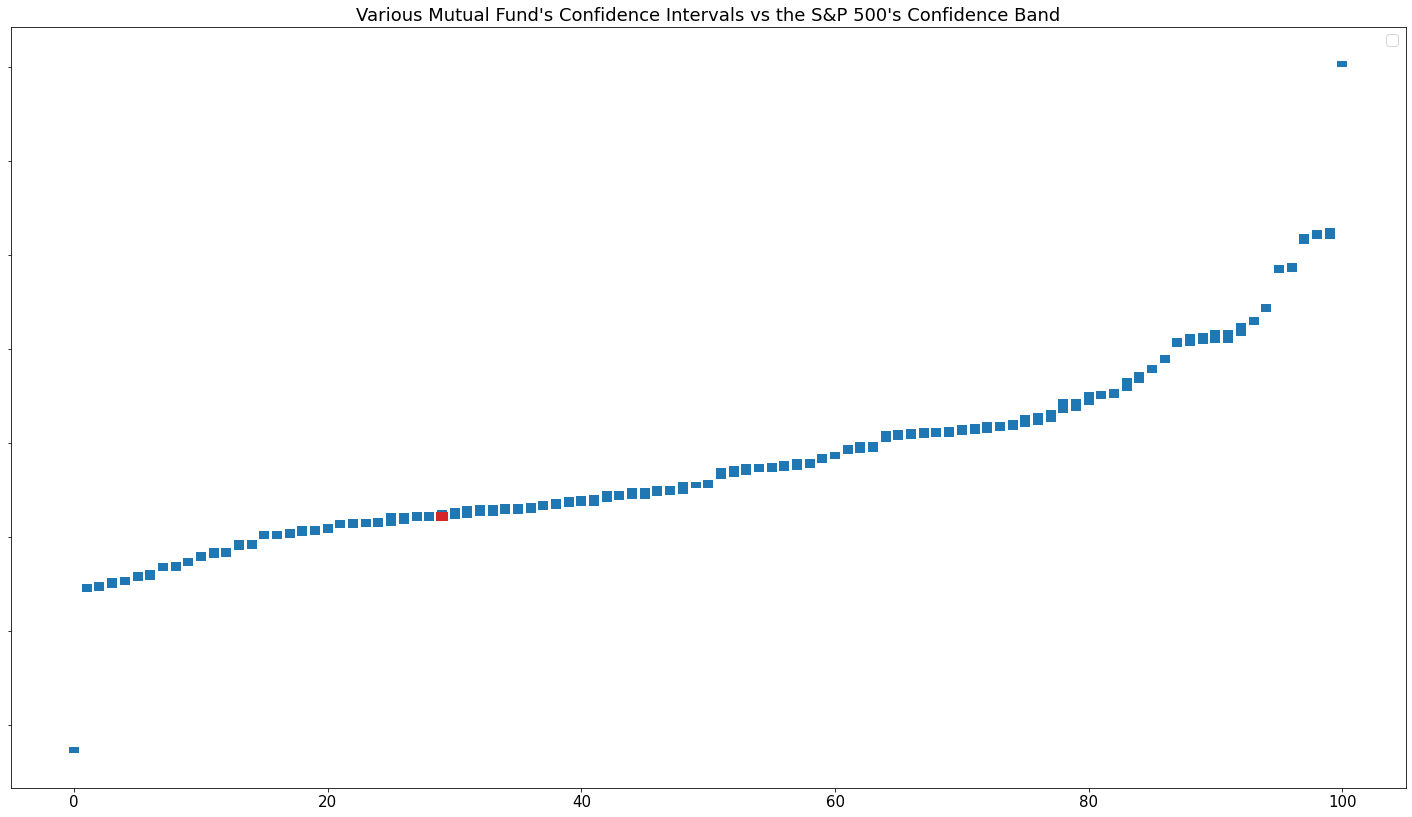

In [58]:
fig, ax = plt.subplots(figsize = (25, 14))
Y_axis = np.arange(len(monthly_returns_CIs[0]))

ax.vlines(x = Y_axis, ymin = monthly_returns_CIs[0].sort_values(), ymax = monthly_returns_CIs[1].sort_values(), linewidth=10 )
ax.vlines(x =  monthly_returns_CIs[1].rank()["S&P 500"], 
          ymin =monthly_returns_CIs[0]["S&P 500"], 
          ymax = monthly_returns_CIs[1]["S&P 500" ], 
          color = "C3",
          linewidth=12 )

#ax.vlines(x = [sp500_CI[0],sp500_CI[1]], ymin = 0, ymax = len(monthly_returns_CIs[0]), label = "S&P 500 CI", color='r', linestyle="--")
ax.set_title("Various Mutual Fund's Confidence Intervals vs the S&P 500's Confidence Band")
ax.set_yticklabels([])
ax.legend()

In [59]:
yearly_close_data = close_data.resample("Y").first()
yearly_changes = yearly_close_data.pct_change()

In [60]:
yearly_return_CIs = confidence_interval(yearly_changes, 0.05)

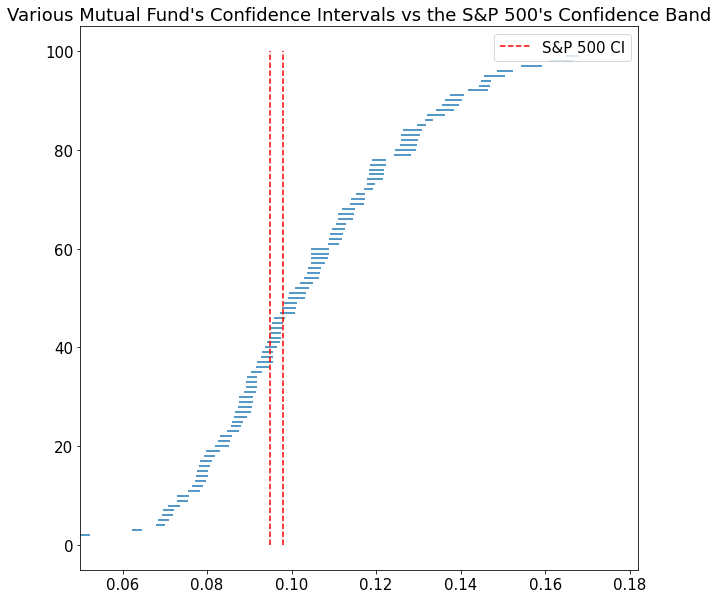

In [61]:
fig, ax = plt.subplots(figsize = (10, 10))
Y_axis = np.arange(len(yearly_return_CIs[0]))

ax.hlines(y = Y_axis, xmin = yearly_return_CIs[0].sort_values(), xmax = yearly_return_CIs[1].sort_values() )
ax.vlines(x = [yearly_return_CIs[0]["S&P 500"],yearly_return_CIs[1]["S&P 500"]], ymin = 0, ymax = 100, label = "S&P 500 CI", color="r", linestyle="--")
ax.set_title("Various Mutual Fund's Confidence Intervals vs the S&P 500's Confidence Band")
ax.set_xlim(0.05)
ax.legend()

# ANOVA 

While using T-tests and Z-tests to analyze means of groups, we were restricted to only being able to compare two groups at a time. What if we wanted to see of there was significant differences between more than two groups? The **ANOVA**, or **Analysis of Variance** techniques allow us to test the null hypothesis that there is no significant difference between $k$ (some integer larger than 2) groups. 

- $H_o$: $\mu_1 = \mu_2 = \cdots = \mu_k$
- $H_a$: At least two of the means are not equal. 

#### Mutual Fund Categories
For our motivating example, we will continue to use our mutual fund data, but we must be able to group our mutual funds into categories. Luckily, the dataset contains a column labeled "Morningstar Category", which is assigned by [Morningstar](http://im.mstar.com/im/newhomepage/Morningstar_Category_Definitions_US_June_2016.pdf) based off of a funds previous holdings statistics and tries to give investors information about a fund's risk and investment strategy. 

In [62]:
mutual_fund_data[["Symbol", "Morningstar Category"]]

,Symbol,Morningstar Category
0,AGTHX,Large Growth
1,FCNTX,Large Growth
2,CWMAX,Large Blend
3,CWMCX,Large Blend
4,CWMEX,Large Blend
...,...,...
95,FDTRX,Large Growth
96,FDYZX,Large Growth
97,BBVLX,Large Value
98,PEYAX,Large Value


We can check to see how many of each category of fund are in our data using the _.value_counts()_ method 

In [63]:
mutual_fund_data["Morningstar Category"].value_counts()

Large Growth      51
Large Value       20
Large Blend       17
Mid-Cap Growth     6
Mid-Cap Value      2
Mid-Cap Blend      1
Small Value        1
Communications     1
Health             1
Name: Morningstar Category, dtype: int64

For ANOVA and for T-test analysis, a sample size of only 2 is not large enough for us to make meaningful assumptions about the population from which the sample was drawn, so we choose to only include the fund categories that contain greater than 2 funds in our data. 

In [64]:
# identify fund categories containing > 2 funds in our data
fund_types = mutual_fund_data["Morningstar Category"].value_counts() > 2
fund_types

Large Growth       True
Large Value        True
Large Blend        True
Mid-Cap Growth     True
Mid-Cap Value     False
Mid-Cap Blend     False
Small Value       False
Communications    False
Health            False
Name: Morningstar Category, dtype: bool

Create variable _relevant_fund_types_ to store the four fund types we will be analyzing:

In [65]:
# pull fund types for which fund_types has value of true 
relevant_fund_types = fund_types[fund_types]
relevant_fund_types

Large Growth      True
Large Value       True
Large Blend       True
Mid-Cap Growth    True
Name: Morningstar Category, dtype: bool

Next, identify the fund symbols in our _mutual_fund_data_ that will be used in the analysis. This will leave us with all but 6 of the funds and 94 rows of data instead of 100: 

In [66]:
# pull relevant funds, should kick out only 6 from the dataset
relevant_funds = mutual_fund_data[mutual_fund_data["Morningstar Category"].isin(relevant_fund_types.index)]
relevant_funds

,Symbol,Name,Morningstar Category,Market cap,Fees
0,AGTHX,American Funds The Growth Fund of America Class A,Large Growth,"$138,592,080,000",0.62%
1,FCNTX,Fidelity Contrafund Fund,Large Growth,"$121,762,870,000",0.74%
2,CWMAX,American Funds Washington Mutual Investors Fun...,Large Blend,"$113,300,000,000",0.63%
3,CWMCX,American Funds Washington Mutual Investors Fun...,Large Blend,"$113,300,000,000",1.40%
4,CWMEX,American Funds Washington Mutual Investors Fun...,Large Blend,"$113,300,000,000",0.87%
...,...,...,...,...,...
95,FDTRX,Franklin DynaTech Fund Class R6,Large Growth,"$9,600,000,000",0.51%
96,FDYZX,Franklin DynaTech Fund Advisor Class,Large Growth,"$9,600,000,000",0.62%
97,BBVLX,Bridge Builder Large Cap Value Fund,Large Value,"$9,500,000,000",0.25%
98,PEYAX,Putnam Large Cap Value Fund Class A,Large Value,"$9,393,340,000",0.91%


Next, we need to pull all of the monthly return data for the _relevant_funds_. First, we create a dictionary with the fund symbols in _relevant_funds_: 

In [67]:
relevant_fund_type_names = {}
for fund_type in relevant_fund_types.index:
    relevant_fund_type_names[fund_type] = relevant_funds["Symbol"][relevant_funds["Morningstar Category"] == fund_type]

In [68]:
relevant_fund_type_names

{'Large Growth': 0     AGTHX
 1     FCNTX
 9     AMCFX
 10    CAFAX
 11    CAFCX
 12    CAFEX
 13    CAFFX
 14    FMACX
 15    TRBCX
 22    FDGRX
 23    FBGRX
 24    AMCPX
 25    EAGRX
 27    FMAGX
 28    HACAX
 30    PRGFX
 36    FOCPX
 37    CNGAX
 38    CNGCX
 39    CNGEX
 40    CNGFX
 41    FNEFX
 42    FOCKX
 48    TWCUX
 49    EGFFX
 50    EGFIX
 51    ANEFX
 61    VAFAX
 63    FCGAX
 64    FGSRX
 65    FIFRX
 70    FKGRX
 72    AULDX
 73    AULGX
 74    AULNX
 75    AULRX
 76    AULYX
 77    AKRSX
 78    MFEIX
 79    POLIX
 80    FKDNX
 82    VWUSX
 83    LSGRX
 84    SEEGX
 91    SBLYX
 92    AKRIX
 93    MFEGX
 94    FDNRX
 95    FDTRX
 96    FDYZX
 99    TWCGX
 Name: Symbol, dtype: object,
 'Large Value': 16    AFMFX
 17    AMRFX
 18    CMLAX
 19    CMLCX
 20    CMLEX
 21    CMLFX
 26    AMRMX
 43    DFLVX
 44    CDDRX
 45    CDDYX
 46    CDIRX
 47    CVIRX
 52    HLIEX
 59    DDFIX
 60    DDFRX
 66    PRFDX
 69    VWNFX
 81    MADVX
 97    BBVLX
 98    PEYAX
 Name: Symbol, d

These symbols are only useful to us insofaras they allow us to pull the monthly returns for them. Our ANOVA analysis only cares about the _categorical_ returns, not the individual funds returns. Hence, we will create a dictionary that combines all of the monthly returns for each fund in a category and treats them as equivalent, because fund type category is the dependent variable of interest for this analysis.

In [69]:
#create dictionary to store all returns for each category
fund_type_returns = {}

#iterate through fund_type_names dictionary we just created to access the names of each fund in each category
for key in relevant_fund_type_names.keys():
    # store key as fund type and value as a list containing all monthly returns for the fund type
    fund_type_returns[key] = []
    for val in relevant_fund_type_names[key]:
        #use .extend() method to add monthly returns to the current list, disregarding the fund's symbol 
        fund_type_returns[key].extend(monthly_returns[val].dropna())

In [70]:
fund_type_returns

{'Large Growth': [0.11627921882310721,
  -0.020833373206581074,
  -0.12234052213745161,
  0.015151627631437625,
  0.07462658871022221,
  0.03055571882916963,
  0.13207527858365165,
  0.03809503116658064,
  0.040411669821878604,
  0.020000145815972648,
  0.06318095592839934,
  0.01639308748806645,
  -0.07661286272400036,
  0.04148472557060012,
  0.06289288429365891,
  0.01183436845360375,
  0.027290638807189183,
  -0.045540859311222426,
  -0.005964177970867679,
  -0.04200034728504631,
  -0.05207094654972466,
  0.0519189130440163,
  0.010729521333651348,
  0.00636951092116167,
  -0.03375538401626543,
  0.004366826921708089,
  -0.0021740491901340864,
  0.04139473813694239,
  -0.023012809661904,
  -0.014989280315389264,
  0.017391104890173814,
  0.057692512297451204,
  0.03838336832873046,
  0.08569143159492043,
  0.03505527294435318,
  -0.005347690171196073,
  0.0358424976718148,
  0.07958464411577992,
  0.001602439309733139,
  0.03840042285058631,
  0.05392898763589571,
  0.0570177243833

We have successfuly wrangled and prepped the data and can begin our ANOVA analysis. 

### Assumptions needed for ANOVA
There are three assumptions that must be met in order to carry out an ANOVA test: 

1. The experimental errors of the data are normally distributed
2. Homoscedasticity - the variances of your factors are all roughly the same (and at least follow the same distribution)
3. Samples are independent - Selection of one sample had no effect on any other sample

(array([1.000e+00, 6.000e+00, 1.800e+01, 1.700e+02, 1.384e+03, 7.570e+03,
        3.296e+03, 2.430e+02, 2.400e+01, 1.000e+00]),
 array([-0.42357707, -0.34719344, -0.27080981, -0.19442617, -0.11804254,
        -0.0416589 ,  0.03472473,  0.11110836,  0.187492  ,  0.26387563,
         0.34025927]),
 <BarContainer object of 10 artists>)

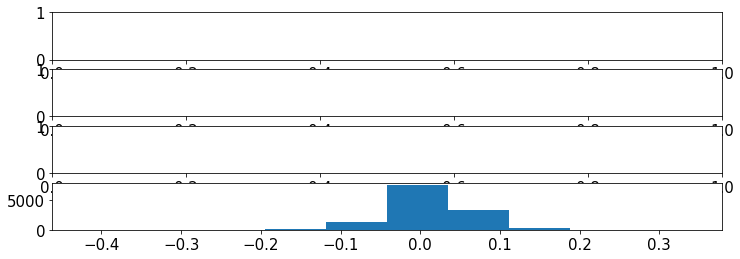

In [71]:
fig, axs = plt.subplots(4, 1 , figsize = (12, 4))
plt.hist(fund_type_returns["Large Growth"])

## F-Statistic
The distribution used for the hypothesis test is a new one. It is called the F distribution, named after Sir Ronald Fisher, an English statistician. The F-statistic is a ratio. There are two sets of degrees of freedom; one for the numerator and one for the denominator. 

The F distribution is derived from the t-distribution. The values of the F distribution are squares of the
corresponding values of the t-distribution. One-Way ANOVA expands the t-test for comparing more than two groups.
The scope of that derivation is beyond the level of this textbook. 

To calculate the F ratio, two estimates of the variance are made:

1. **Variance between samples**: An estimate of $\sigma^2$ that is the variance of the sample means multiplied by n (when the sample sizes are the same.). If the samples are different sizes, the variance between samples is weighted to account for the different sample sizes. The variance is also called **variation due to treatment or explained variation.**

2. **Variance within samples**: An estimate of $\sigma^2$ that is the average of the sample variances (also known as a pooled variance). When the sample sizes are different, the variance within samples is weighted. The variance is also called **the variation due to error or unexplained variation.**

- $SS_b$ = the sum of squares that represents the variation among the different samples

- $SS_w$ = the sum of squares that represents the variation within samples that is due to chance.

To find a "sum of squares" means to add together squared quantities that, in some cases, may be weighted. We used sum of squares to calculate the sample variance and the sample standard deviation. 

MS means "mean square." $MS_b$ is the variance between groups, and $MS_w$ is the variance within groups. These measurements are the total sum of squares of their variances divided by the degrees of freedomom of the measure to give a mean value. 

#### Caluculating the F-Statistic

#### Counting Statistics
In order to accurately calculate the _Mean sum of squares_ we need to have denominator to divide the _total sum of squares_ by. For the sum of squares between groups, this is one minus the number of groups, and for the sum of squares within groups, this is the total number of observations minus the number of groups.

- $k$ = the number of different groups
- $n_j$ = the size of the $j^{th}$ group
- $N$ = total number of all the values combined (total sample size: $\sum{n_j}$)
- $df$'s for the numerator(between samples): $df_b = k – 1$
- $df$'s for the denominator($df$'s within samples): $df_w = k – 1$ 

These counting measures can be packaged into one function and demonstrated with our mutual fund categories: 

In [72]:
def get_anova_counts(*args):
    k = len(args)
    N = 0
    for arg in args:
        N += len(arg)
    dfbn = k - 1
    dfwn = N - k

    return k, N, dfbn, dfwn

In [73]:
get_anova_counts(fund_type_returns["Large Growth"],
                 fund_type_returns['Large Value'],
                 fund_type_returns['Large Blend'],
                 fund_type_returns['Mid-Cap Growth'])

(4, 23079, 3, 23075)

Our data has 4 groups with 23079 total observations. 

#### Sum of Squares Between Groups
- Explained variation: sum of squares representing variation among the different samples:

    - $SS_{b} = \sum_{j = 1}^{k}{n_j(\bar{x_j} - \bar{x})^2}$
    
    
This measures the _total_ variation between the samples. For each group passed, the mean of all values is subtracted from the mean of the group, and that value is squared, then multiplied by the size of each group, because the measure must be scaled to the size of the group to capture the total sum of squares. 

In [74]:
def SSB(*args):
    ssb = 0
    alldata = np.concatenate(args)

    grand_mean = np.mean(alldata)

    for arg in args:
        group_mean = np.mean(arg)

        n = len(arg)
        val = n * (group_mean - grand_mean)**2

        ssb += val

    return ssb

In [75]:
SSB(fund_type_returns["Large Growth"], fund_type_returns['Large Value'],
    fund_type_returns['Large Blend'], fund_type_returns['Mid-Cap Growth'])

0.019414228114599516

- Unexplained variation: sum of squares representing variation within samples:

    - $SS_w = \sum_{j = 1}^{k}{\sum_{i = 1}^{n_j}{(x_i - \bar{x_j})^2}}$
    
This measure adds up the squared difference between all observations in a group and that individual group's mean. This function will iterate once for each individual observation in the groups, much more than SSB which only iterates once for each group. 

In [76]:
def SSW(*args):
    ssw = 0
    for arg in args: 
        group_mean = np.mean(arg)
        val = 0 
        for i in arg:
            val += np.sum(i - group_mean)**2
        ssw += val
    return ssw

In [77]:
SSW(fund_type_returns["Large Growth"],
               fund_type_returns['Large Value'],
               fund_type_returns['Large Blend'],
               fund_type_returns['Mid-Cap Growth'])

52.78957219451308

 - Total variation across the dataset: 

    - $SS_t = SS_b + SS_w$
    
This is a measure of the total sum of squares in the dataset. Simply an addition of SSB and SSW. 

In [78]:
def get_sum_square_stats(*args): 
    ssw = SSW(*args)
    ssb = SSB(*args)
    sst = ssb + ssw
    return ssw, ssb, sst

In [79]:
get_sum_square_stats(fund_type_returns["Large Growth"],
               fund_type_returns['Large Value'],
               fund_type_returns['Large Blend'],
               fund_type_returns['Mid-Cap Growth'])

(52.78957219451308, 0.019414228114599516, 52.808986422627676)

#### Mean Sum of Squares 

For the F-statistic and by extension the ANOVA test, the _mean_ sum of squares with and between of are greater interest than the total sum of squares. Dividing each total member by the appropriate degrees of freedom allows us to compare ratios, and determine the true observed difference in variance. 

- Mean square (variance estimate) explained by the different groups:
$MS_b = \frac{SS_b}{df_b} = \frac{SS_b}{k-1}$
- Mean square (variance estimate) that is due to chance (unexplained): $MS_w = \frac{SS_w}{df_w} = \frac{SS_w}{n - k}$

The one-way ANOVA test depends on the fact that $MS_b$ can be influenced by population differences among means of the several groups. Since $MS_w$ compares values of each group to its own group mean, the fact that group means might
be different does not affect $MS_w$. The null hypothesis says that all groups are samples from populations having the same normal distribution. The alternate
hypothesis says that at least two of the sample groups come from populations with different normal distributions. If the null hypothesis is true, $MS_b$ and $MS_w$ should both estimate the same value. 

Finally, we arrive at the **F-Statistic**, which will function for us as the T-Statistic did earlier this chapter, as an input into one minus its cumulative density function to recieve a p-value telling us the likelihood of its occurence if our null hypothesis was true. 

- $ F = \frac{MS_b}{MS_w}$

With a density function:
<h3 align="center">
    <font size="5">
        $ f(x, df_1, df_2) = \frac{df_2^{df_2/2} df_1^{df_1/2} x^{df_1 / 2-1}}
                        {(df_2+df_1 x)^{(df_1+df_2)/2}
                         \beta(df_1/2, df_2/2)}$
    </font>
    </h3> 



where $df_1$ and $df_2$ are the
shape parameters and
$\beta$ is the beta function.  The formula for the beta function
is
<ul>
$B(a, b) = \int_0^1 t^{a-1}(1-t)^{b-1}dt
        = \frac{\Gamma(a)\Gamma(b)}{\Gamma(a+b)}$,
 
<p>where <span class="math notranslate nohighlight">\(\Gamma\)</span> is the gamma function.</p>
    
These funtions could be implemented manually using basic math symbols, but for our purposes, importing them from Scipy will be much more pragmatic.
    
We create the last accessory function in our ANOVA analysis called _finish_anova_. This models the survival function of the F-distribution(1 - CDF), which returns the p-value in the same way the survival function of t-distribution gave us a p-value. 

In [80]:
from scipy.stats import f as f_dist
def finish_anova(f, dfwn, dfbn): 
    # use scipy to plug f-value into f distribution to return p-value
     p_value =  1 - f_dist.cdf(f, dfwn, dfbn)
    
     if p_value > .05:
        return_string = "F-value: " + str(f) + ", P-value: " + str(
            p_value) + ", Fail to reject null hypothesis."
     else:
        return_string = "F-value: " + str(f) + ", P-value: " + str(
            round(p_value, 5)) + ", Reject null hypothesis."

     return return_string

The user-called funtion _anova_ will accept a variable number of arguments and perform an ANOVA test. We use the _get_anova_counts_ function, the _get_sum_square_stats_ function, and use the returned values to calculate MSB, MSW, and f. We then send it off to _finish_anova_ for our p-value and a packaged message displaying the result. 

In [81]:
# use *args command to accept variable number of arguments
def anova(*args):

    k, N, dfbn, dfwn  = get_anova_counts(*args)
    
    ssw, ssb, sst = get_sum_square_stats(*args)

    msb = ssb / dfbn
    msw = ssw / dfwn
    f = msb / msw

    return finish_anova(f, dfbn, dfwn)

Finally, we can test the hypothesis that fund category influences growth. 

In [82]:
anova(fund_type_returns["Large Growth"],
      fund_type_returns['Large Value'],
      fund_type_returns['Large Blend'],
      fund_type_returns['Mid-Cap Growth'])

'F-value: 2.828736150728818, P-value: 0.03699, Reject null hypothesis.'

Compare to equivalent SciPy function: 

In [83]:
stats.f_oneway(fund_type_returns["Large Growth"],
               fund_type_returns['Large Value'],
               fund_type_returns['Large Blend'],
               fund_type_returns['Mid-Cap Growth'])

F_onewayResult(statistic=2.8287361507288216, pvalue=0.036985604694737204)

These results suggest that from 1980 to 2020, one type of fund perfomed significantly differently than th either funds. One issue with the ANOVA is that it does not tell us which fund that was. However, there are various post-hoc tests we can do to find the outlier.

##  Multiple Comparisons Procedure 

The first would be just to print the means, and see which one is highest. There are several hazards we can run into here(i.e., don't know error bars) but it gives an idea as to which fund may have caused the significant result. 

In [84]:
fund_types_list = ["Large Growth", "Large Value", "Large Blend", "Mid-Cap Growth"]
for ftype in fund_types_list: 
    print(ftype+" mean: "+(str)(np.mean(fund_type_returns[ftype])))

Large Growth mean: 0.009704763462297612
Large Value mean: 0.007858101648202564
Large Blend mean: 0.008325037060111744
Mid-Cap Growth mean: 0.01095978524872245


Mid-Cap Growth had the highest group mean.

### Bonferroni Correction
A more robust test would be to run t-tests on each pair of groups to find which ones exhibit significant differences from each other. But we run into a problem if we use the same $\alpha$ value of 0.05 for these tests, as the likelihood of having an erroneous conclusion increases quickly as we perform multiple tests. For instance, we have 4 groups of funds, and there are 6 unique pairs for which t-tests can be run. For this "family" of 6 comparisons, the familywise error rate becomes $(1 + 0.05)^6 - 1 = 0.34$. More generally, if there are $m$ comparisons perfomed with a confidence value of $1 - \alpha$ per comparison, the familywise error rate is $1 - (1 - \alpha)^m$. 

One way to solve this issue is to alter the per-comparison $\alpha$ to be $\frac{\alpha}{m}$. This is known as the __Bonferroni Correction__. This makes the familywise error rate reflect the desired confidence level. 

First, we show results with no Bonferroni Correction: 

In [112]:
for ftype1 in fund_types_list: 
    for ftype2 in fund_types_list: 
        result = t_test(fund_type_returns[ftype1], fund_type_returns[ftype2], "independent")
        scipy_result = stats.ttest_ind(fund_type_returns[ftype1], fund_type_returns[ftype2])
        if("Reject" in result):
            print("\nftype1: " + ftype1 + "\nftype2: " + ftype2 + "\n" + result, scipy_result) 


ftype1: Large Growth
ftype2: Large Value
T-value: 2.4885131550741066, P-value: 0.01284, Reject null hypothesis. Ttest_indResult(statistic=2.2208053279512203, pvalue=0.026377032963572387)

ftype1: Large Value
ftype2: Large Growth
T-value: -2.4885131550741066, P-value: 0.01284, Reject null hypothesis. Ttest_indResult(statistic=-2.2208053279512203, pvalue=0.026377032963572387)

ftype1: Large Value
ftype2: Mid-Cap Growth
T-value: -1.9671926721881312, P-value: 0.0493, Reject null hypothesis. Ttest_indResult(statistic=-2.338963422731845, pvalue=0.01936938734210311)

ftype1: Mid-Cap Growth
ftype2: Large Value
T-value: 1.9671926721881312, P-value: 0.0493, Reject null hypothesis. Ttest_indResult(statistic=2.338963422731845, pvalue=0.01936938734210311)


As we can see, none of the p-values are below $0.05 / 6 = 0.0833$, and we conclude that no two fund types had statistically different returns with the new $\alpha$, but there was a difference between the fund types in aggregate.